In [49]:
run "/Users/octavia/Dropbox/fire/fire_model/startup.py"

## Read parameter file

In [50]:
# Simulation batch
sim_dir = os.path.join(project_dir, "model_output", "data")
file_dir = os.path.join(sim_dir, "all_sims")
if os.path.isdir(file_dir)  == False:
    os.mkdir(file_dir)
    
sys.path.append(sim_dir)
if "params" in sys.modules:
    del sys.modules["params"]
from params import all_params


In [51]:
all_sims = read_all_sims(file_dir)

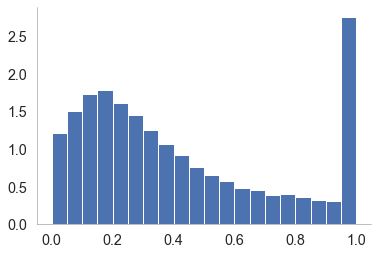

In [52]:
plt.hist(p.severity_list[:, 0], 20, density=1);

In [53]:
np.mean(p.severity_list[:, 0]>0.95)

0.13704656377786573

In [54]:
sim = all_sims.iloc[0]

In [55]:
p.ignition_type

'random'

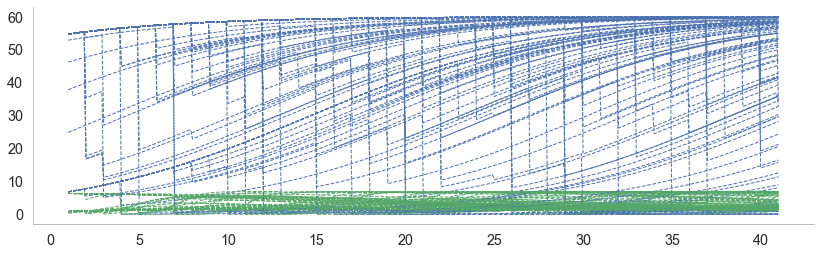

In [104]:
fig, ax = plt.subplots(1, figsize = (14,4) )

for key in all_sims.index[:100]:
    p = all_sims.loc[key][0]
    line_u = ax.plot(p.t_p, 
        p.G_u_list, 'b--', lw = 1, 
        label ="upper canopy")       
    line_l = ax.plot(p.t_p, 
        p.G_l_list, 'g--', lw = 1, 
        label ="upper canopy")          
    

In [98]:
res = pd.DataFrame()
var_list = list(default_params().keys())

for key in all_sims.index:

    p = all_sims.loc[key][0]

    param = pd.Series(vars(p))[var_list]
    
    g_u =  p.G_u/p.k_u
    g_l =  p.G_l/p.k_l
    
    g_uo =  p.G_uo/p.k_u
    g_lo =  p.G_lo/p.k_l
    results = pd.Series({
                "G_u" : p.G_u, 
                "G_l" : p.G_l, 
                "G_uo" : p.G_uo, 
                "G_lo" : p.G_lo,         
                "g_l" : g_l, 
                "g_u" : g_u,
                "g_lo" : g_lo,
                "g_uo" : g_uo,        
                "severity_list" : list(p.record.l_severity),
                        })
    param = param.append(results)

    res = res.append(param, ignore_index = True)
res.index = all_sims.index

In [116]:
res["conifer"] = res["g_l"] < res["g_u"]

In [118]:
res["conifer"].mean()

0.711

In [119]:
res["conifer_o"] = res["g_lo"] < res["g_uo"]
res["conifer_o"].mean()

0.891

Text(0, 0.5, '$G_u$')

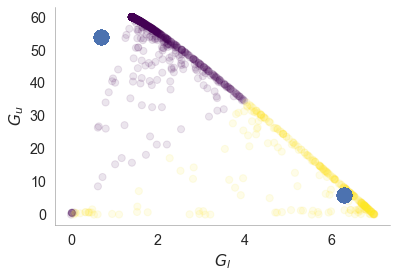

In [121]:
plt.scatter(res["G_l"] ,res["G_u"], c = res["g_u"] < res["g_l"], s= 50, alpha = 0.1, cmap = "viridis")
plt.scatter(res["G_lo"],res["G_uo"], c = "b" , s = 200)
ax = plt.gca()
ax.set_xlabel("$G_l$")
ax.set_ylabel("$G_u$")